Data Preparation for LSTM

In [8]:
import os
print("Current working directory:", os.getcwd())


Current working directory: d:\Data Science\LSTM-stockPredictor\notebooks


In [9]:
import sys
sys.path.append('../src')  # Point to /src

import importlib
import data_loader
importlib.reload(data_loader)

df = data_loader.load_and_preprocess_data('../data/sp500.csv')


Columns after stripping whitespace:
['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
Columns after stripping whitespace:
['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


In [10]:


from sklearn.preprocessing import MinMaxScaler
close_prices = df[['Close']].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(close_prices)

import numpy as np

def create_sequence(close_prices, seq_length=60):
    X=[]
    y=[]
    for i in range(seq_length, len(close_prices)):
        X.append(close_prices[i-seq_length:i,0])
        y.append(close_prices[i,0])
    return np.array(X),np.array(y)

X,y=create_sequence(data_scaled,60)

X= X.reshape((X.shape[0], X.shape[1], 1))
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
split = int(0.8*len(X))
X_train,X_test = X[:split], X[split:]
y_train, y_test = y[:split],y[split:]


Shape of X: (3842, 60, 1)
Shape of y: (3842,)


LSTM model architecture

In [21]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(StockLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
    
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out,_=self.lstm(x)
        last_out=lstm_out[:,-1,:]
        output=self.fc(last_out)
        return output
    

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = StockLSTM().to(device)

In [23]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor= torch .tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

In [35]:
num_epochs = 200
train_losses = []

from tqdm.notebook import trange

for epoch in trange(num_epochs, desc="Training Epochs"):
    model.train()
    
    outputs=model(X_train_tensor)
    loss=criterion(outputs.squeeze(), y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if(epoch+1)%5 == 0:
        print(f"Epoch [{epoch +1}/{num_epochs}], Loss:{loss.item():.6f}")

Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5/200], Loss:0.000132
Epoch [10/200], Loss:0.000132
Epoch [15/200], Loss:0.000131
Epoch [20/200], Loss:0.000130
Epoch [25/200], Loss:0.000129
Epoch [30/200], Loss:0.000129
Epoch [35/200], Loss:0.000128
Epoch [40/200], Loss:0.000127
Epoch [45/200], Loss:0.000126
Epoch [50/200], Loss:0.000126
Epoch [55/200], Loss:0.000125
Epoch [60/200], Loss:0.000124
Epoch [65/200], Loss:0.000124
Epoch [70/200], Loss:0.000123
Epoch [75/200], Loss:0.000122
Epoch [80/200], Loss:0.000122
Epoch [85/200], Loss:0.000121
Epoch [90/200], Loss:0.000120
Epoch [95/200], Loss:0.000120
Epoch [100/200], Loss:0.000119
Epoch [105/200], Loss:0.000118
Epoch [110/200], Loss:0.000118
Epoch [115/200], Loss:0.000117
Epoch [120/200], Loss:0.000117
Epoch [125/200], Loss:0.000116
Epoch [130/200], Loss:0.000116
Epoch [135/200], Loss:0.000115
Epoch [140/200], Loss:0.000114
Epoch [145/200], Loss:0.000114
Epoch [150/200], Loss:0.000113
Epoch [155/200], Loss:0.000113
Epoch [160/200], Loss:0.000112
Epoch [165/200], Loss:0.0001

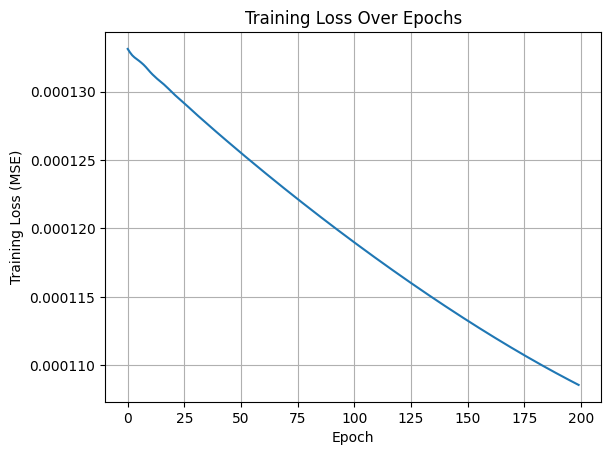

In [37]:
import matplotlib.pyplot as plt

plt.plot(train_losses)  
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()


In [38]:
model.eval()
with torch.no_grad():
    y_pred = model(torch.tensor(X_test).float())
    test_loss = criterion(y_pred.squeeze(), torch.tensor(y_test).float())
    print(f"Test Loss: {test_loss.item():.5f}")


Test Loss: 0.00163


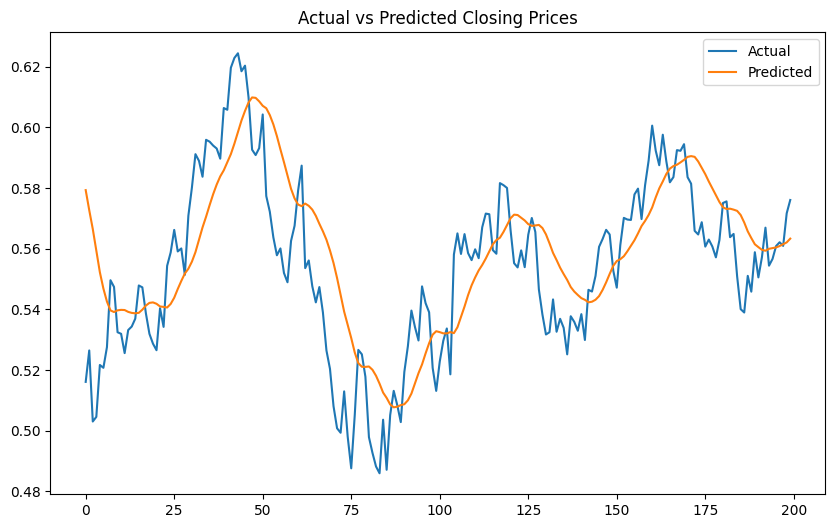

In [39]:
plt.figure(figsize=(10,6))
plt.plot(y_test[:200], label='Actual')
plt.plot(y_pred[:200].numpy(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Closing Prices')
plt.show()


In [36]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cpu


In [41]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())


None
False
